# Нейронные сети
__Суммарное количество баллов: 10__

В этом домашнем задании можно использовать готовые классы библиотек PyTorch, Keras, TensorFlow.

### Задание 1 (4 балла)

Создайте сеть из трех сверточных слоев по 8 сверток 3х3 и двух полносвязных слоев по 64 нейрона. 

Обучите сеть на датасете mnist с тремя разными функциями активации в слоях (sigmoid, tanh, ReLU).

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import imageio
import matplotlib.pyplot as plt

from glob import glob

sns.set(style="whitegrid", font="serif", font_scale=1.1)

# imports from other HWs
import nbimporter

from hw01 import train_test_split

Importing Jupyter notebook from hw01.ipynb


In [2]:
def read_mnist(path_to_csv):
    X = np.loadtxt(path_to_csv, skiprows=1, delimiter=",", usecols=range(1, 785))
    y = np.loadtxt(path_to_csv, skiprows=1, delimiter=",", usecols=0)
    return torch.tensor(X).float().reshape(X.shape[0], 28, 28).unsqueeze(1), torch.tensor(y).long()

X, y = read_mnist('data/mnist.csv')
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)

In [3]:
class SinmpleNet(torch.nn.Module):
    def __init__(self, activation):
        super(SinmpleNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=3, padding=2)
        self.act1  = activation()
       
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1)
        self.act2  = activation()
        
        self.fc1   = torch.nn.Linear(64, 64)
        self.act3  = activation()
        
        self.fc2   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        
        return x

In [4]:
def train_network(net, batch_size=100, epoch=10):
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    test_accuracy_history = []
    test_loss_history = []

    for _ in range(epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index + batch_size]

            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test)

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
        test_accuracy_history.append(accuracy)
        
    return test_accuracy_history

### Sigmoid

Accurancy on test at last epoch: tensor(0.9235)


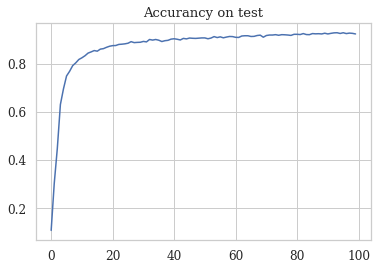

In [5]:
simple_net = SinmpleNet(torch.nn.Sigmoid)
test_accuracy_history = train_network(simple_net, epoch=100)

print('Accurancy on test at last epoch:', test_accuracy_history[-1])
plt.title('Accurancy on test')
plt.plot(test_accuracy_history)

### Tanh

Accurancy on test at last epoch: tensor(0.9390)


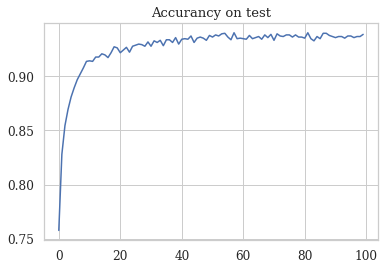

In [6]:
simple_net = SinmpleNet(torch.nn.Tanh)
test_accuracy_history = train_network(simple_net, epoch=100)

print('Accurancy on test at last epoch:', test_accuracy_history[-1])
plt.title('Accurancy on test')
plt.plot(test_accuracy_history)

### ReLU

Accurancy on test at last epoch: tensor(0.9540)


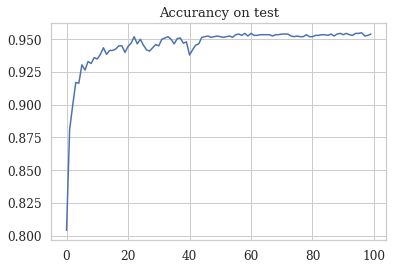

In [7]:
simple_net = SinmpleNet(torch.nn.ReLU)
test_accuracy_history = train_network(simple_net, epoch=100)

print('Accurancy on test at last epoch:', test_accuracy_history[-1])
plt.title('Accurancy on test')
plt.plot(test_accuracy_history)

### Задание 2 (6 баллов)

Достигните точности 87% на test датасете notMNIST.

Архитектура сети может быть любая. Можно использовать Data Augmentation.

In [8]:
def load_not_mnist(folder_path):
    labels = next(os.walk(folder_path))[1]
    X, y = [], []
    for label_i, label in enumerate(labels):
        for image_path in glob(folder_path + label + '/*.png'):
            image = imageio.imread(image_path)
            
            X.append(image)
            y.append(label_i)
    return torch.tensor(np.array(X)).float().unsqueeze(1), torch.tensor(np.array(y)).long()
    
X, y = load_not_mnist('data/notMNIST_small/')
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)

In [9]:
class ComplexNet(torch.nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        
        self.batch_norm0 = torch.nn.BatchNorm2d(1)

        self.conv1 = torch.nn.Conv2d(1, 16, 3, padding=2)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.do1 = torch.nn.Dropout2d(0.15)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.do2 = torch.nn.Dropout2d(0.15)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.do3 = torch.nn.Dropout2d(0.15)

        self.fc1   = torch.nn.Linear(7 * 7 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.do4 = torch.nn.Dropout2d(0.15)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        self.do5 = torch.nn.Dropout2d(0.15)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.do1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.do2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = self.do3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.do4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.do5(x)
        x = self.fc3(x)
        
        return x

Accurancy on test at last epoch: tensor(0.9514)


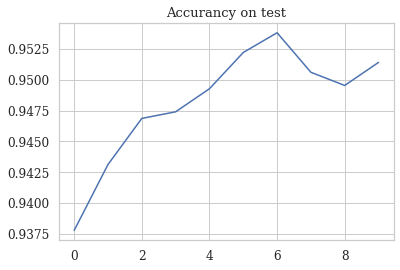

In [11]:
test_accuracy_history = train_network(ComplexNet())

print('Accurancy on test at last epoch:', test_accuracy_history[-1])
plt.title('Accurancy on test')
plt.plot(test_accuracy_history)